<img height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px">

<h1>2019 Deep Learning _ HW5 </h1>

Sentiment Analysis using RNN (LSTM)

- Myeong-Ha Hwang

In [0]:
import numpy as np 
import pandas as pd 
import nltk
nltk.download('all') #You only use this line for nltk sub package at first time 
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
lemmatizer = WordNetLemmatizer()

#set random seed for the session and also for tensorflow that runs in background for keras
#set_random_seed(123)
#random.seed(123)

In [10]:
# Data upload from windows
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file"{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving test.tsv to test (1).tsv
Saving train.tsv to train (1).tsv
User uploaded file"test.tsv" with length 3367149 bytes
User uploaded file"train.tsv" with length 8481022 bytes


In [16]:
# Data loading from colab
import pandas as pd
import io
train = pd.read_csv(io.StringIO(uploaded['train.tsv'].decode('utf-8')), sep='\t')
test = pd.read_csv(io.StringIO(uploaded['test.tsv'].decode('utf-8')), sep='\t')
train.head()
#print(train.head())
#print(test.head())
#print(train.shape)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [17]:
#Preprocessing Reference: https://www.kaggle.com/chiranjeevbit/movie-review-prediction/notebook

from tqdm import tqdm

#Method for cleaning the reviews, tokenize and lemmatize them.
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

#cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 66292/66292 [00:34<00:00, 1903.63it/s]

156060
66292


In [18]:
#Collect the dependent values and convert to one-hot encoded output using to_categorical
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

#Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_sentences, y_target, test_size=0.2, stratify=y_target)

#Getting the no of unique words and max length of a review available in the list of cleaned reviews
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 591686.75it/s]

13735
48


In [19]:
#Actual tokenizer of keras and convert to sequences

tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [0]:
#Early stopping to prevent overfitting
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [32]:
#Model using Keras LSTM
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 48, 300)           4120500   
_________________________________________________________________
lstm_19 (LSTM)               (None, 48, 128)           219648    
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 505       
Total params: 4,396,561
Trainable params: 4,396,561
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Fit the model

#This is done for learning purpose only. One can play around with different hyper parameters combinations
#and try increase the accuracy even more. For example, a different learning rate, an extra dense layer 
# before output layer, etc. Cross validation could be used to evaluate the model and grid search 
# further to find unique combination of parameters that give maximum accuracy. This model has a validation
#accuracy of around 66.5%

history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=256, verbose=1, callbacks=callback)

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 126s 1ms/step - loss: 1.0283 - acc: 0.5895 - val_loss: 0.8589 - val_acc: 0.6432
Epoch 2/10
124848/124848 [==============================] - 121s 973us/step - loss: 0.8341 - acc: 0.6585 - val_loss: 0.8236 - val_acc: 0.6624
Epoch 3/10
124848/124848 [==============================] - 121s 970us/step - loss: 0.7745 - acc: 0.6791 - val_loss: 0.8185 - val_acc: 0.6689
Epoch 4/10
124848/124848 [==============================] - 121s 970us/step - loss: 0.7401 - acc: 0.6926 - val_loss: 0.8172 - val_acc: 0.6689
Epoch 5/10
124848/124848 [==============================] - 120s 964us/step - loss: 0.7154 - acc: 0.7013 - val_loss: 0.8329 - val_acc: 0.6674


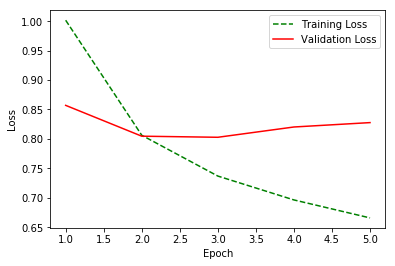

In [24]:
#Plotting
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'g--')
plt.plot(epoch_count, history.history['val_loss'], 'r-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
#make the predictions with trained model and submit the predictions.
y_pred=model.predict_classes(X_test)

In [0]:
uploaded = files.upload()

In [0]:
for fn in uploaded.keys():
    print('User uploaded file"{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    
#sub_file = pd.read_csv('../input/sampleSubmission.csv',sep=',')
sub_file = pd.read_csv(io.StringIO(uploaded['sampleSubmission.csv'].decode('utf-8')))
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission.csv',index=False)

In [0]:
#Submission data download
files.download('Submission.csv')